This lab on Cross-Validation is a python adaptation of p. 190-194 of "Introduction to Statistical Learning
with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. 
It is based on the work of R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).



# 5.3.1 The Validation Set Approach

Before you start upgrade your scikit-learn library to version 1.0. 

In [1]:
def check_sklearn():
    from importlib_metadata import metadata
    version = metadata('scikit-learn').get('Version')
    # print(version)
    major, minor = list(map(int, version.split('.')[:2]))
    if major==0:
        print(f"sklearn version is {version}, please upgrade by uncommenting and running the next cell!")
    else:
        print(f"Your sklearn version=`{version}` seems to be up to date") 
check_sklearn()

Your sklearn version=`1.0` seems to be up to date


In [2]:
#! pip install -U scikit-learn

In [3]:
import pandas as pd
import numpy as np
import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.datasets as smd

In this section, we'll explore the use of the validation set approach in order to estimate the
test error rates that result from fitting various linear models on the `Auto` data set.

In [4]:
df1 = smd.get_rdataset('Auto', 'ISLR').data.set_index('name')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 27.6+ KB


We begin by using the `sample()` function to split the set of observations
into two halves, by selecting a random subset of 196 observations out of
the original 392 observations. We refer to these observations as the training
set.

We'll use the `random_state` parameter in order to set a seed for
`python`’s random number generator, so that you'll obtain precisely the same results each time. It is generally a good idea to set a random seed when performing an analysis such as cross-validation
that contains an element of randomness, so that the results obtained can be reproduced precisely at a later time.

In [5]:
train_df = df1.sample(196, random_state = 1)
test_df = df1[~df1.index.isin(train_df.index)].dropna(how = 'all')
print(train_df.index.sort_values(), test_df.index.sort_values())


def extract(df,y_name=None, X_names=None):
    res = dict(X = df[X_names] if X_names else df.drop(columns=[y_name]))
    if y_name:
        res['y'] = df[y_name]
    return res 

## or using sklearn
use_sklearn = True
if use_sklearn:
    train_df, test_df = train_test_split(df1, test_size=len(df1)-196, shuffle=True, random_state=1)
    # print(train_df.index.sort_values(), test_df.index.sort_values())
    
    # people typically do this
    X_train, X_test, y_train,y_test = train_test_split(df1[['horsepower']], df1.mpg, test_size=len(df1)-196, shuffle=True, random_state=1)
    #print(X_train.head())
    #print(y_train.head())
    
# print(extract(train_df,'mpg','horsepower'))

Index(['amc ambassador brougham', 'amc ambassador dpl', 'amc ambassador sst',
       'amc gremlin', 'amc gremlin', 'amc hornet', 'amc hornet', 'amc hornet',
       'amc hornet', 'amc hornet sportabout (sw)',
       ...
       'volkswagen rabbit l', 'volkswagen type 3', 'volvo 144ea',
       'volvo 264gl', 'volvo diesel', 'vw dasher (diesel)', 'vw pickup',
       'vw rabbit', 'vw rabbit c (diesel)', 'vw rabbit custom'],
      dtype='object', name='name', length=196) Index(['amc concord', 'amc concord', 'amc concord d/l', 'amc concord dl 6',
       'amc pacer d/l', 'amc rebel sst', 'audi 100 ls', 'audi 5000s (diesel)',
       'bmw 320i', 'buick century limited',
       ...
       'toyota tercel', 'volkswagen 411 (sw)', 'volkswagen model 111',
       'volkswagen rabbit custom', 'volkswagen rabbit custom diesel',
       'volkswagen scirocco', 'volkswagen super beetle', 'volvo 145e (sw)',
       'volvo 244dl', 'volvo 245'],
      dtype='object', name='name', length=154)


We then use `LinearRegression()` to fit a linear regression to predict `mpg` from `horsepower` using only
the observations corresponding to the training set.

In [7]:
lm = skl_lm.LinearRegression()
lm.fit(X=train_df[['horsepower']], y=train_df['mpg']) ## y_name='mpg', X_names=['horsepower']))

LinearRegression()

We now use the `predict()` function to estimate the response for the test
observations, and we use `sklearn` to caclulate the MSE.

In [8]:
lm.predict(test_df[['horsepower']])

array([24.41268594, 27.8555737 , 27.8555737 , 22.06526247, 29.10753289,
       26.60361451, 28.79454309, 16.11845633, 25.19516043, 28.3250584 ,
       21.59577777, 27.6990788 , 19.2483543 , 28.63804819, 26.44711962,
       17.68340532, 26.44711962, 32.08093595,  5.16381346, 23.94320124,
       27.8555737 , 22.37825226, 16.11845633, 12.98855837,  8.60670122,
       16.11845633, 28.95103799, 23.94320124, 22.37825226, 26.44711962,
       16.90093082, 25.82114002, 15.33598184, 22.06526247, 23.16072675,
       17.68340532, 24.72567574, 23.16072675, 29.10753289, 25.82114002,
        9.8586604 , 12.20608388, 20.50031348, 23.94320124, 23.94320124,
       22.37825226, 16.11845633, 28.95103799, 23.94320124,  5.94628795,
       16.11845633, 24.72567574, 25.50815023, 26.44711962, 29.89000738,
       24.41268594, 21.59577777, 26.29062472, 25.50815023, 30.20299717,
       26.29062472, 26.13412982, 29.42052268, 22.37825226, 25.50815023,
       25.50815023, 25.82114002, 14.55350735, 28.48155329, 11.42

In [10]:
from sklearn.metrics import mean_squared_error, make_scorer

def model_mse(model, df, y_name):
    X, y = df[model.feature_names_in_], df[y_name] 
    pred = model.predict(X)
    return mean_squared_error(pred, y)

m_mse = make_scorer(mean_squared_error)
    
print(f"test MSE: {model_mse(lm, test_df, 'mpg'):.2f}")
print(f"test MSE: {m_mse(lm, test_df[['horsepower']], test_df['mpg']):.2f}")

test MSE: 24.80
test MSE: 24.80


In [11]:
m_mse?

Signature:      m_mse(estimator, X, y_true, sample_weight=None)
Type:           _PredictScorer
String form:    make_scorer(mean_squared_error)
File:           ~/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py
Docstring:      <no docstring>
Call docstring:
Evaluate predicted target values for X relative to y_true.

Parameters
----------
estimator : object
    Trained estimator to use for scoring. Must have a predict_proba
    method; the output of that is used to compute the score.

X : {array-like, sparse matrix}
    Test data that will be fed to estimator.predict.

y_true : array-like
    Gold standard target values for X.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

Returns
-------
score : float
    Score function applied to prediction of estimator on X.


Therefore, the estimated test MSE for the linear regression fit is 25.14. We
can use the `PolynomialFeatures()` function to estimate the test error for the polynomial
and cubic regressions.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Quadratic
model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), skl_lm.LinearRegression())
model.fit(**extract(train_df, 'mpg', ['horsepower']))          
print(f"Quadratic polynomial regression: test mse {model_mse(model, test_df, 'mpg'):.2f}")

# Cubic
model = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), skl_lm.LinearRegression())
model.fit(**extract(train_df, 'mpg', ['horsepower']))          
print(f"    Cubic polynomial regression: test mse {model_mse(model, test_df, 'mpg'):.2f}")


Quadratic polynomial regression: test mse 18.85
    Cubic polynomial regression: test mse 18.81


These error rates are 20.94 and 20.88, respectively. If we choose a different
training set instead, then we will obtain somewhat different errors on the
validation set. We can test this out by setting a different random seed:

In [13]:
train_df = df1.sample(196, random_state = 1)
test_df = df1[~df1.index.isin(train_df.index)].dropna(how = 'all')

for d in range(1,4):
    model = make_pipeline(PolynomialFeatures(degree=d, include_bias=False), 
                          skl_lm.LinearRegression())
    model.fit(X=train_df[['horsepower']], y=train_df['mpg']) ## , ['horsepower']))          
    print(f"Degree-{d}: test mse {model_mse(model, test_df, 'mpg'):.2f}")

Degree-1: test mse 25.01
Degree-2: test mse 20.94
Degree-3: test mse 20.88


Using this split of the observations into a training set and a validation
set, we find that the validation set error rates for the models with linear,
quadratic, and cubic terms are 25.11, 19.72, and 19.92, respectively.

These results are consistent with our previous findings: a model that
predicts `mpg` using a quadratic function of `horsepower` performs better than
a model that involves only a linear function of `horsepower`, and there is
little evidence in favor of a model that uses a cubic function of `horsepower`.

# 5.3.2 Leave-One-Out Cross-Validation

The LOOCV estimate can be automatically computed for any generalized linear model in `R`. In `python` the `sklearn` library does not provide such a function, but it can be easily implemented.

In [14]:
def lm_loocv(X, y):
    """only works for OLS"""
    X, y = np.asarray(X), np.asarray(y)
    # include the constant effect
    X = np.concatenate([np.ones((X.shape[0],1)),X],axis=-1)
    q,_ = np.linalg.qr(X)
    # Compute the leverage values
    hat_diag = (q**2).sum(axis=1)
    # predictions when all observations are included
    pred = np.dot(q,np.dot(q.T,y))
    # Corrections due to leaving out one observation (see textbook pp. 202 eq (5.2))
    return (-y*hat_diag + pred)/(1-hat_diag), ((pred-y)/(1-hat_diag))**2
                           

In [15]:
preds0, scores0 = lm_loocv(**extract(df1, 'mpg', ['horsepower']))
print(f"Folds: {len(scores0)} MSE: {scores0.mean():.2f} STD: {scores0.std():.2f}")

Folds: 392 MSE: 24.23 STD: 36.80


In [16]:

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

LOOCV = KFold(n_splits=len(df1), random_state=None, shuffle=False)

scores = cross_val_score(skl_lm.LinearRegression(), 
                         X= df1[['horsepower']], 
                         y=df1.mpg,
                         ## **extract(df1, 'mpg', ['horsepower']), 
                         scoring="neg_mean_squared_error", 
                         cv=LOOCV,
                         n_jobs=1)

preds = cross_val_predict(skl_lm.LinearRegression(), 
                          **extract(df1, 'mpg', ['horsepower']), 
                          cv=LOOCV)
print(f"Folds: {len(scores)} MSE: {-scores.mean():.2f} STD: {scores.std():.2f}")


Folds: 392 MSE: 24.23 STD: 36.80


The two methods produces the same prediction, the difference is the order of the truncation error of `float64`.

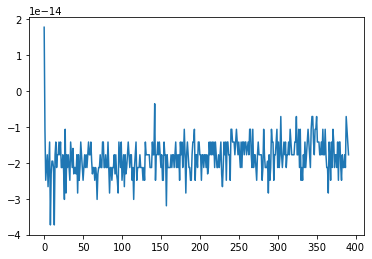

In [17]:
plt.plot(preds.flatten()-preds0)

Our cross-validation estimate for the test error is approximately 24.23. We can repeat this procedure for increasingly complex polynomial fits.
To automate the process, we use the `for()` function to initiate a for loop
which iteratively fits polynomial regressions for polynomials of order `i = 1`
to `i = 5` and computes the associated cross-validation error. 

This command may take a couple of minutes to run.

In [18]:
v = extract(df1, "mpg", ["horsepower"])
X,y = v['X'], v['y']
for i in range(1,6):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_current = poly.fit_transform(X)
    scores = cross_val_score(skl_lm.LinearRegression(), 
                             X_current, 
                             y, 
                             scoring="neg_mean_squared_error", 
                             cv=LOOCV,
                             n_jobs=1)
    
    print(f"Degree-{i} polynomial MSE: {-scores.mean():.2f} STD: {scores.std():.2f}")


Degree-1 polynomial MSE: 24.23 STD: 36.80
Degree-2 polynomial MSE: 19.25 STD: 35.00
Degree-3 polynomial MSE: 19.33 STD: 35.77
Degree-4 polynomial MSE: 19.42 STD: 35.68
Degree-5 polynomial MSE: 19.03 STD: 35.32


In [19]:
v = extract(df1, "mpg", ["horsepower"])
X,y = v['X'], v['y']
for i in range(1,6):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_current = poly.fit_transform(X)
    preds, scores = lm_loocv(X_current, y)
    print(f"Degree-{i} polynomial MSE: {scores.mean():.2f} STD: {scores.std():.2f}")


Degree-1 polynomial MSE: 24.23 STD: 36.80
Degree-2 polynomial MSE: 19.25 STD: 35.00
Degree-3 polynomial MSE: 19.33 STD: 35.77
Degree-4 polynomial MSE: 19.42 STD: 35.68
Degree-5 polynomial MSE: 19.03 STD: 35.32


Here we see a sharp drop in the estimated test MSE between
the linear and quadratic fits, but then no clear improvement from using
higher-order polynomials.

# 5.3.3 k-Fold Cross-Validation

The `KFold` function can (intuitively) also be used to implement `k`-fold CV. Below we
use `k = 10`, a common choice for `k`, on the `Auto` data set. We once again set
a random seed and initialize a vector in which we will print the CV errors
corresponding to the polynomial fits of orders one to ten.

In [20]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

np.random.seed(42)
v = extract(df1, "mpg", ["horsepower"])
X,y = v['X'], v['y']
for i in range(1,11):
    model = make_pipeline(PolynomialFeatures(degree=i, include_bias=False), 
                          skl_lm.LinearRegression())
    scores = cross_val_score(model, 
                             X=X, y=y, 
                             scoring="neg_mean_squared_error", 
                             cv=cv,
                             n_jobs=1)
    
    print(f"Degree-{i:<2} polynomial MSE: {-scores.mean():.2f} STD: {scores.std():.2f}")


Degree-1  polynomial MSE: 24.10 STD: 4.82
Degree-2  polynomial MSE: 19.18 STD: 5.13
Degree-3  polynomial MSE: 19.21 STD: 5.14
Degree-4  polynomial MSE: 19.21 STD: 4.93
Degree-5  polynomial MSE: 18.76 STD: 4.70
Degree-6  polynomial MSE: 18.64 STD: 4.51
Degree-7  polynomial MSE: 18.81 STD: 4.57
Degree-8  polynomial MSE: 18.98 STD: 4.71
Degree-9  polynomial MSE: 18.94 STD: 4.87
Degree-10 polynomial MSE: 18.79 STD: 4.84


Notice that the computation time is **much** shorter than that of LOOCV.
(In principle, the computation time for LOOCV for a least squares linear
model should be faster than for `k`-fold CV, due to the availability of the
formula (5.2) for LOOCV; however, unfortunately the `KFold()` function
does not make use of this formula.) We still see little evidence that using
cubic or higher-order polynomial terms leads to lower test error than simply
using a quadratic fit.

# An Application to Default Data

Now that you're armed with more useful technique for resampling your data, let's try fitting a model for the `Default` dataset:

In [21]:
df2 = smd.get_rdataset('Default', 'ISLR')
df2.data.__doc__= df2.__doc__
df2 = df2.data
# df2 = pd.read_csv('Default.csv', na_values='?').dropna()
df2.describe()
df2.info()
df2.default

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


0       No
1       No
2       No
3       No
4       No
        ..
9995    No
9996    No
9997    No
9998    No
9999    No
Name: default, Length: 10000, dtype: object

First we'll try just holding out a random 20% of the data:

In [22]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report

if False:
    for i in range(1,11):
        train_df2 = df2.sample(8000, random_state = i)
        test_df2 = df2[~df2.isin(train_df2)].dropna(how = 'all')

        # Fit a logistic regression to predict default using balance
        model = smf.glm('default~balance', data=train_df2, family=sm.families.Binomial())
        result = model.fit()
        predictions_nominal = [ "Yes" if x < 0.5 else "No" for x in result.predict(test_df2)]
        print("----------------")
        print("Random Seed = " + str(i) + "")
        print("----------------")
        print(confusion_matrix(test_df2["default"], 
                           predictions_nominal))
        print(classification_report(test_df2["default"], 
                                predictions_nominal, 
                                digits = 3))
        print()
    

Our accuracy is really high on this data, but we're getting different error rates depending on how we choose our test set. That's no good!

Unfortunately this dataset is too big for us to run LOOCV, so we'll have to settle for `k`-fold. In the space below, build a logistic model on the full `Default` dataset and then run 5-fold cross-validation to get a more accurate estimate of your test error rate:

In [23]:
# Your code here

# 5.3.4 The Bootstrap

We illustrate the use of the bootstrap in the simple example of Section 5.2,
as well as on an example involving estimating the accuracy of the linear
regression model on the `Auto`data set.

# Estimating the Accuracy of a Statistic of Interest

One of the great advantages of the bootstrap approach is that it can be
applied in almost all situations. No complicated mathematical calculations
are required. Performing a bootstrap analysis in R entails only two steps.

- First, we must create a function that computes the statistic of interest.
- Second, we use the `boot()` function, which is part of the boot library, to perform the bootstrap by repeatedly sampling observations from the data set with replacement.

The `Portfolio` data set in the `ISLR` package is described in Section 5.2. It has variables called `X` and `Y`. 

In [24]:
portfolio_df = smd.get_rdataset('Portfolio', 'ISLR')
portfolio_df.data.__doc__ = portfolio_df.__doc__
portfolio_df = portfolio_df.data
portfolio_df.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


In [25]:
# print(portfolio_df.__doc__)

To illustrate the use of the bootstrap on this data, we must first create
a function, `alpha()`, which takes as input the data and outputs the estimate for $\alpha$ (described in more detail on page 187).

In [26]:
def alpha(X,Y):
    Sigma = np.cov(X,Y)
    return (Sigma[1,1]-Sigma[0,1])/ (Sigma[0,0]+Sigma[1,1]-2*Sigma[0,1])

This function returns, or outputs, an estimate for $\alpha$ based on applying
(5.7) to the observations indexed by the argument index. For instance, the
following command tells `python` to estimate $\alpha$ using all 100 observations.

In [27]:
X = portfolio_df.X[0:100]
y = portfolio_df.Y[0:100]
print(alpha(X,y))

0.57583207459283


The next command uses the `sample()` function to randomly select 100 observations
from the range 1 to 100, with replacement. This is equivalent
to constructing a new bootstrap data set and recomputing $\hat{\alpha}$ based on the
new data set.

In [28]:
dfsample = portfolio_df.sample(frac=1, replace=True)
print(alpha(**dfsample))

0.4557262562988247


We can implement a bootstrap analysis by performing this command many
times, recording all of the corresponding estimates for $\alpha$, and computing the resulting standard deviation. However, the `boot()`function automates
this approach. Below we produce $1,000$ bootstrap estimates for $\alpha$:

In [29]:
def boot(df, fun, n=1000):
    gen = range(n) if isinstance(n, int) else n
    res = pd.DataFrame([fun(df.sample(frac=1, replace=True)) for i in gen])
    return res.aggregate(['mean', 'std'])
#{'mean':res.mean(axis=0), 'std':res.std(axis=0)}
res = boot(portfolio_df, lambda x: {'alpha': alpha(**x)})
res
# res.aggregate(['mean', 'std'])

,alpha
mean,0.578030
std,0.089962


The final output shows that using the original data, $\hat{\alpha} = 0.58$, and that the bootstrap estimate for $SE(\hat{\alpha})$ is 0.09.

# Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used to assess the variability of the coefficient
estimates and predictions from a statistical learning method. Here
we use the bootstrap approach in order to assess the variability of the
estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression
model that uses horsepower to predict mpg in the Auto data set. We
will compare the estimates obtained using the bootstrap to those obtained
using the formulas for $SE(\hat{\beta}_0)$ and $SE(\hat{\beta}_1)$ described in Section 3.1.2.

First let's refresh our memory about a linear model of the `Auto` dataset:

In [30]:
auto_df = smd.get_rdataset('Auto', 'ISLR')
auto_df.data.__doc__ = auto_df.__doc__
auto_df = auto_df.data.dropna()
auto_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [31]:
clf = skl_lm.LinearRegression().fit(**extract(auto_df, 'mpg', ['horsepower']))
print(clf.coef_, clf.intercept_)

[-0.15784473] 39.93586102117047


Next, we use the `boot()`function to compute the standard errors of 1,000
bootstrap estimates for the intercept and slope terms:

In [32]:
def boot(df, fun, n=1000):
    gen = range(n) if isinstance(n, int) else n
    res = pd.DataFrame([fun(df.sample(frac=1, replace=True)) for i in gen])
    return res.aggregate(['mean', 'std'])

In [33]:
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

df = auto_df[['mpg','horsepower']]

np.random.seed(42)

def intercept_slope(df):
    fitted = skl_lm.LinearRegression().fit(**extract(df, 'mpg'))
    res = dict(zip(fitted.feature_names_in_, fitted.coef_))
    res['intercept'] = fitted.intercept_
    return res
    
boot(df, intercept_slope, n=tqdm(range(1000)))


  0%|          | 0/1000 [00:00<?, ?it/s]

,horsepower,intercept
mean,-0.158345,39.969382
std,0.007503,0.869087


In [34]:
def intercept_slope(df):
    fitted = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                           skl_lm.LinearRegression()).fit(**extract(df, 'mpg'))
    res = dict(zip(fitted[0].get_feature_names_out(), fitted[-1].coef_))
    res['intercept'] = fitted[-1].intercept_
    return res

boot(df, intercept_slope, n=tqdm(range(1000)))

  0%|          | 0/1000 [00:00<?, ?it/s]

,horsepower,horsepower^2,intercept
mean,-0.466665,0.001233,56.919738
std,0.034252,0.000123,2.150039


In [35]:
make_pipeline(PolynomialFeatures(2, include_bias=False), 
              skl_lm.LinearRegression())

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])